# Tutorial 5: L-R pairs analysis

The Nanostring CosMx Spatial Molecular Imaging (SMI) dataset used in this analysis was obtained from the official Nanostring repository: https://nanostring.com/products/cosmx-spatial-molecular-imager/nsclc-ffpe-dataset/. For L-R interaction analysis, we used a curated ligand-receptor pair list that combines entries from the SiGra framework and the IUPHAR/BPS Guide to PHARMACOLOGY database.

In [7]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
from GraphST import GraphST

device = torch.device('cuda:1')

LR PAIR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
# this function is from scipy 1.11
def fdr(ps, *, axis=0, method='bh'):
    # Input Validation and Special Cases
    ps = np.asarray(ps)

    ps_in_range = (np.issubdtype(ps.dtype, np.number)
                   and np.all(ps == np.clip(ps, 0, 1)))
    if not ps_in_range:
        raise ValueError("`ps` must include only numbers between 0 and 1.")

    methods = {'bh', 'by'}
    if method.lower() not in methods:
        raise ValueError(f"Unrecognized `method` '{method}'."
                         f"Method must be one of {methods}.")
    method = method.lower()

    if axis is None:
        axis = 0
        ps = ps.ravel()

    axis = np.asarray(axis)[()]
    if not np.issubdtype(axis.dtype, np.integer) or axis.size != 1:
        raise ValueError("`axis` must be an integer or `None`")

    if ps.size <= 1 or ps.shape[axis] <= 1:
        return ps[()]

    ps = np.moveaxis(ps, axis, -1)
    m = ps.shape[-1]
    order = np.argsort(ps, axis=-1)
    ps = np.take_along_axis(ps, order, axis=-1)  # this copies ps
    i = np.arange(1, m+1)
    ps *= m / i

    # Theorem 1.3 of [2]
    if method == 'by':
        ps *= np.sum(1 / i)
    np.minimum.accumulate(ps[..., ::-1], out=ps[..., ::-1], axis=-1)

    # Restore original order of axes and data
    np.put_along_axis(ps, order, values=ps.copy(), axis=-1)
    ps = np.moveaxis(ps, -1, axis)

    return np.clip(ps, 0, 1)

In [2]:
nano_gene = pd.read_csv('../Nanostring/all_in_one.csv')

gene_col = nano_gene.columns[-980:].to_list()
gene_col = [i.lower() for i in gene_col]

lr_pairs = pd.read_csv('../mergeall_LR_pairs_uniq.csv')
lr_pairs = lr_pairs.drop_duplicates()
print('Total number of pairs:', lr_pairs.shape[0])
lr_pairs['pair1'] = lr_pairs['Pair.Name'].apply(lambda x: x.split('_')[0].lower())
lr_pairs['pair2'] = lr_pairs['Pair.Name'].apply(lambda x: x.split('_')[1].lower())
print('Number of pair1', lr_pairs['pair1'].unique().shape[0])
print('Number of pair2', lr_pairs['pair2'].unique().shape[0])

# only keep those rows that both 'pair1' and 'pair2' in gene_col
lr_pairs = lr_pairs[lr_pairs['pair1'].isin(gene_col) & lr_pairs['pair2'].isin(gene_col)]
print('Number of pair1', lr_pairs['pair1'].unique().shape[0])
print('Number of pair2', lr_pairs['pair2'].unique().shape[0])
print('Total number of pairs:', lr_pairs.shape[0])

Total number of pairs: 2097
Number of pair1 693
Number of pair2 620
Number of pair1 189
Number of pair2 159
Total number of pairs: 480


In [4]:
# label_map = {'Tumors': 0, 'Fibroblast': 1, 'Lymphocyte': 2, 'Mcell': 3, 'Neutrophil': 4, 'Endothelial': 5, 'Epithelial': 6, 'Mast': 7}
label_map = {'tumors': 0, 'fibroblast': 1, 'lymphocyte': 2, 'Mcell': 3, 'neutrophil': 4, 'endothelial': 5, 'epithelial': 6, 'mast': 7}

def load_Nano_data(id, root_path='./'):
    data = pd.read_csv(os.path.join(root_path, 'all_in_one.csv'))
    gene_feature_col = pd.read_csv(os.path.join(root_path, 'Lung9_Rep1_exprMat_file.csv')).columns[2:] #980 gene-related features 

    y = data[data['fov'] == id]['cell_type'] # the cell type is string type
    y = y.map(label_map).to_numpy()

    gene_fea = data[data['fov'] == id][gene_feature_col].to_numpy().astype(float)
    
    return gene_fea, y, np.array([data[data['fov'] == id]['CenterY_local_px'], data[data['fov'] == id]['CenterX_local_px']]).T, gene_feature_col

In [8]:
import os
import scanpy as sc
path = './best_res/Nanostring/'

e_specific = []
r_specific = []

raw_exp = []
enhanced_expression_matrix = []

for i in range(1, 21):
    _raw_exp, gt, loc, gene_col = load_Nano_data(i, root_path='../Nanostring/')
    path_ = os.listdir(os.path.join(path, str(i).zfill(3)))[0]
    raw_exp.append(_raw_exp)
    
    file_path = '/home/wudanyang/SC/nanostring_slice/fov' + str(i)
    adata = sc.read_h5ad(os.path.join(file_path, 'sampledata.h5ad'))
    n_clusters = len(adata.obs['merge_cell_type'].value_counts())
    model = GraphST.GraphST(adata, device=device)
    adata = model.train()
    enhanced_expression_matrix.append(adata.obsm['emb'])
    print(i)

gene_col = [i.lower() for i in gene_col]
raw_exp = np.concatenate(raw_exp, axis=0)
enhanced_expression_matrix = np.concatenate(enhanced_expression_matrix, axis=0)

Begin to train ST data...


100%|██████████| 600/600 [00:05<00:00, 100.29it/s]


Optimization finished for ST data!
1
Begin to train ST data...


100%|██████████| 600/600 [00:04<00:00, 134.51it/s]


Optimization finished for ST data!
2
Begin to train ST data...


100%|██████████| 600/600 [00:04<00:00, 136.50it/s]


Optimization finished for ST data!
3
Begin to train ST data...


100%|██████████| 600/600 [00:05<00:00, 118.42it/s]


Optimization finished for ST data!
4
Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 185.31it/s]


Optimization finished for ST data!
5
Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 177.79it/s]


Optimization finished for ST data!
6
Begin to train ST data...


100%|██████████| 600/600 [00:05<00:00, 113.35it/s]


Optimization finished for ST data!
7
Begin to train ST data...


100%|██████████| 600/600 [00:04<00:00, 149.86it/s]


Optimization finished for ST data!
8
Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 174.02it/s]


Optimization finished for ST data!
9
Begin to train ST data...


100%|██████████| 600/600 [00:04<00:00, 148.88it/s]


Optimization finished for ST data!
10
Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 155.16it/s]


Optimization finished for ST data!
11
Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 192.98it/s]


Optimization finished for ST data!
12
Begin to train ST data...


100%|██████████| 600/600 [00:04<00:00, 123.07it/s]


Optimization finished for ST data!
13
Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 156.79it/s]


Optimization finished for ST data!
14
Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 168.38it/s]


Optimization finished for ST data!
15
Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 168.94it/s]


Optimization finished for ST data!
16
Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 150.97it/s]


Optimization finished for ST data!
17
Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 155.58it/s]


Optimization finished for ST data!
18
Begin to train ST data...


100%|██████████| 600/600 [00:04<00:00, 148.65it/s]


Optimization finished for ST data!
19
Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 179.83it/s]


Optimization finished for ST data!
20


In [9]:
# l2 norm 
raw_exp = raw_exp / np.linalg.norm(raw_exp, axis=1, keepdims=True)
raw_expression_matrix = raw_exp
raw_expression_matrix = pd.DataFrame(raw_expression_matrix, columns=gene_col)

# enhanced_expression_matrix = np.where(enhanced_expression_matrix<0, 0, enhanced_expression_matrix)
enhanced_expression_matrix = enhanced_expression_matrix / (np.linalg.norm(enhanced_expression_matrix, axis=1, keepdims=True)+1e-10)
enhanced_expression_matrix = pd.DataFrame(enhanced_expression_matrix, columns=gene_col)

assert raw_expression_matrix.shape == enhanced_expression_matrix.shape

raw_expression_matrix = raw_expression_matrix.T
enhanced_expression_matrix = enhanced_expression_matrix.T

In [ ]:
e_specific = []
r_specific = []
results = pd.DataFrame(columns=['LR_pair', 'p_value', 'p_value_enhanced'])


for id in range(len(lr_pairs)):
    ligand_gene = lr_pairs.iloc[id]['pair1']
    receptor_gene = lr_pairs.iloc[id]['pair2']
    pair = lr_pairs.iloc[id]['Pair.Name']

    # Extract expression data
    ligand_raw = raw_expression_matrix.loc[ligand_gene]
    receptor_raw = raw_expression_matrix.loc[receptor_gene]
    ligand_enhanced = enhanced_expression_matrix.loc[ligand_gene]
    receptor_enhanced = enhanced_expression_matrix.loc[receptor_gene]

    # Perform paired t-test
    test_result_raw = ttest_rel(ligand_raw, receptor_raw)
    test_result_enhanced = ttest_rel(ligand_enhanced, receptor_enhanced)
    results.loc[id] = [pair,test_result_raw[1],test_result_enhanced[1]]

# 对原始和增强 p 值进行 FDR 校正
results['FDR_raw'] = fdr(results['p_value'])
results['FDR_enhanced'] = fdr(results['p_value_enhanced'])

# 计算 -log10(FDR) 用于可视化
results['logFDR_raw'] = -np.log10(results['FDR_raw'] + 1e-10)
results['logFDR_enhanced'] = -np.log10(results['FDR_enhanced'] + 1e-10)

# 基于 FDR 判断显著性
results['Shared'] = (results['FDR_raw'] < 0.05) & (results['FDR_enhanced'] < 0.05)
results['Specific'] = (results['FDR_raw'] < 0.05) | (results['FDR_enhanced'] < 0.05)
results['Specific'] = results['Specific'] & (~results['Shared'])

results['Not Significant'] = (results['FDR_raw'] >= 0.05) & (results['FDR_enhanced'] >= 0.05)

# 将结果合并为 'Shared', 'Specific', 'Not significant' 三类
results['pair_type'] = results[['Shared', 'Specific', 'Not Significant']].idxmax(axis=1)

# 标记只在增强后显著的配体-受体对
results['specific_enhanced'] = (results['FDR_raw'] >= 0.05) & (results['FDR_enhanced'] < 0.05)

# 记录数量
e_specific.append(results['specific_enhanced'].sum())
r_specific.append(results['Specific'].sum() - results['specific_enhanced'].sum())

print(e_specific, r_specific)

[16] [12]


In [11]:
results.to_csv('figs/Nanostring/25-3-17/LR_pair_FDR_SiGra.csv', index=False)

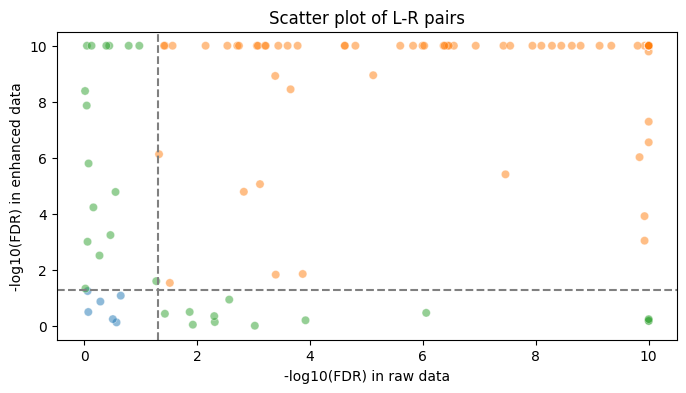

In [14]:
plt.figure(figsize=(8, 4))

from matplotlib import colormaps as cm

c_list = cm.get_cmap('tab10').colors
## 去除legend
sns.scatterplot(data=results, x='logFDR_raw', y='logFDR_enhanced', hue='pair_type', 
                palette={'Shared': c_list[1], 'Specific': c_list[2], 'Not Significant': c_list[0]}, alpha=0.5, legend=False)

plt.axhline(y=-np.log10(0.05), linestyle='--', color='grey')
plt.axvline(x=-np.log10(0.05), linestyle='--', color='grey')
plt.title("Scatter plot of L-R pairs")
plt.xlabel("-log10(FDR) in raw data")
plt.ylabel("-log10(FDR) in enhanced data")
## set legend to outside the plot
# plt.legend(title='Pair Type', loc='best', framealpha=0.6)
# plt.legend(title='Pair Type', loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('./figs/Nanostring/LR_pair_visualization_SiGra.png', dpi=500)
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
# this function is from scipy 1.11
def fdr(ps, *, axis=0, method='bh'):
    # Input Validation and Special Cases
    ps = np.asarray(ps)

    ps_in_range = (np.issubdtype(ps.dtype, np.number)
                   and np.all(ps == np.clip(ps, 0, 1)))
    if not ps_in_range:
        raise ValueError("`ps` must include only numbers between 0 and 1.")

    methods = {'bh', 'by'}
    if method.lower() not in methods:
        raise ValueError(f"Unrecognized `method` '{method}'."
                         f"Method must be one of {methods}.")
    method = method.lower()

    if axis is None:
        axis = 0
        ps = ps.ravel()

    axis = np.asarray(axis)[()]
    if not np.issubdtype(axis.dtype, np.integer) or axis.size != 1:
        raise ValueError("`axis` must be an integer or `None`")

    if ps.size <= 1 or ps.shape[axis] <= 1:
        return ps[()]

    ps = np.moveaxis(ps, axis, -1)
    m = ps.shape[-1]
    order = np.argsort(ps, axis=-1)
    ps = np.take_along_axis(ps, order, axis=-1)  # this copies ps
    i = np.arange(1, m+1)
    ps *= m / i

    # Theorem 1.3 of [2]
    if method == 'by':
        ps *= np.sum(1 / i)
    np.minimum.accumulate(ps[..., ::-1], out=ps[..., ::-1], axis=-1)

    # Restore original order of axes and data
    np.put_along_axis(ps, order, values=ps.copy(), axis=-1)
    ps = np.moveaxis(ps, -1, axis)

    return np.clip(ps, 0, 1)

In [2]:
nano_gene = pd.read_csv('../Nanostring/all_in_one.csv')

gene_col = nano_gene.columns[-980:].to_list()
gene_col = [i.lower() for i in gene_col]

lr_pairs = pd.read_csv('../mergeall_LR_pairs_uniq.csv')
lr_pairs = lr_pairs.drop_duplicates()
print(lr_pairs.shape)
lr_pairs['pair1'] = lr_pairs['Pair.Name'].apply(lambda x: x.split('_')[0].lower())
lr_pairs['pair2'] = lr_pairs['Pair.Name'].apply(lambda x: x.split('_')[1].lower())

# only keep those rows can 'pair1' and 'pair2' in gene_col
lr_pairs = lr_pairs[lr_pairs['pair1'].isin(gene_col) & lr_pairs['pair2'].isin(gene_col)]
print(lr_pairs.shape)

(2097, 1)
(480, 3)


In [3]:
# label_map = {'Tumors': 0, 'Fibroblast': 1, 'Lymphocyte': 2, 'Mcell': 3, 'Neutrophil': 4, 'Endothelial': 5, 'Epithelial': 6, 'Mast': 7}
label_map = {'tumors': 0, 'fibroblast': 1, 'lymphocyte': 2, 'Mcell': 3, 'neutrophil': 4, 'endothelial': 5, 'epithelial': 6, 'mast': 7}

def load_Nano_data(id, root_path='./'):
    data = pd.read_csv(os.path.join(root_path, 'all_in_one.csv'))
    gene_feature_col = pd.read_csv(os.path.join(root_path, 'Lung9_Rep1_exprMat_file.csv')).columns[2:] #980 gene-related features 

    y = data[data['fov'] == id]['cell_type'] # the cell type is string type
    y = y.map(label_map).to_numpy()

    gene_fea = data[data['fov'] == id][gene_feature_col].to_numpy().astype(float)
    
    return gene_fea, y, np.array([data[data['fov'] == id]['CenterY_local_px'], data[data['fov'] == id]['CenterX_local_px']]).T, gene_feature_col

In [12]:
import os
import numpy as np

path = './best_res/Nanostring/'

raw_exp = []
enhanced_expression_matrix = []
for i in range(1, 21):
    _raw_exp, gt, loc, gene_col = load_Nano_data(i, root_path='../Nanostring/')
    path_ = os.listdir(os.path.join(path, str(i).zfill(3)))[0]
    _enhanced_expression_matrix = np.load(os.path.join(path, str(i).zfill(3), path_, 'recon_RNA.npy'), allow_pickle=True)
    raw_exp.append(_raw_exp)
    enhanced_expression_matrix.append(_enhanced_expression_matrix)

    print(i)

gene_col = [i.lower() for i in gene_col]
raw_exp = np.concatenate(raw_exp, axis=0)
enhanced_expression_matrix = np.concatenate(enhanced_expression_matrix, axis=0)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [15]:
# l2 norm 
raw_exp = raw_exp / np.linalg.norm(raw_exp, axis=1, keepdims=True)
raw_expression_matrix = raw_exp
raw_expression_matrix = pd.DataFrame(raw_expression_matrix, columns=gene_col)

# enhanced_expression_matrix = np.where(enhanced_expression_matrix<0, 0, enhanced_expression_matrix)
enhanced_expression_matrix = enhanced_expression_matrix / (np.linalg.norm(enhanced_expression_matrix, axis=1, keepdims=True)+1e-10)
enhanced_expression_matrix = pd.DataFrame(enhanced_expression_matrix, columns=gene_col)

assert raw_expression_matrix.shape == enhanced_expression_matrix.shape

raw_expression_matrix = raw_expression_matrix.T
enhanced_expression_matrix = enhanced_expression_matrix.T

In [28]:
e_specific = []
r_specific = []
results = pd.DataFrame(columns=['LR_pair', 'p_value', 'p_value_enhanced'])


for id in range(len(lr_pairs)):
    ligand_gene = lr_pairs.iloc[id]['pair1']
    receptor_gene = lr_pairs.iloc[id]['pair2']
    pair = lr_pairs.iloc[id]['Pair.Name']

    # Extract expression data
    ligand_raw = raw_expression_matrix.loc[ligand_gene]
    receptor_raw = raw_expression_matrix.loc[receptor_gene]
    ligand_enhanced = enhanced_expression_matrix.loc[ligand_gene]
    receptor_enhanced = enhanced_expression_matrix.loc[receptor_gene]

    # Perform paired t-test
    test_result_raw = ttest_rel(ligand_raw, receptor_raw)
    test_result_enhanced = ttest_rel(ligand_enhanced, receptor_enhanced)
    results.loc[id] = [pair,test_result_raw[1],test_result_enhanced[1]]

# 对原始和增强 p 值进行 FDR 校正
results['FDR_raw'] = fdr(results['p_value'])
results['FDR_enhanced'] = fdr(results['p_value_enhanced'])

# 计算 -log10(FDR) 用于可视化
results['logFDR_raw'] = -np.log10(results['FDR_raw'] + 1e-10)
results['logFDR_enhanced'] = -np.log10(results['FDR_enhanced'] + 1e-10)

# 基于 FDR 判断显著性
results['Shared'] = (results['FDR_raw'] < 0.05) & (results['FDR_enhanced'] < 0.05)
results['Specific'] = (results['FDR_raw'] < 0.05) | (results['FDR_enhanced'] < 0.05)
results['Specific'] = results['Specific'] & (~results['Shared'])

results['Not Significant'] = (results['FDR_raw'] >= 0.05) & (results['FDR_enhanced'] >= 0.05)

# 将结果合并为 'Shared', 'Specific', 'Not significant' 三类
results['pair_type'] = results[['Shared', 'Specific', 'Not Significant']].idxmax(axis=1)

# 标记只在增强后显著的配体-受体对
results['specific_enhanced'] = (results['FDR_raw'] >= 0.05) & (results['FDR_enhanced'] < 0.05)

# 记录数量
e_specific.append(results['specific_enhanced'].sum())
r_specific.append(results['Specific'].sum() - results['specific_enhanced'].sum())

print(e_specific, r_specific)

[21] [6]


In [32]:
results.to_csv('figs/Nanostring/25-3-17/LR_pair_FDR.csv', index=False)

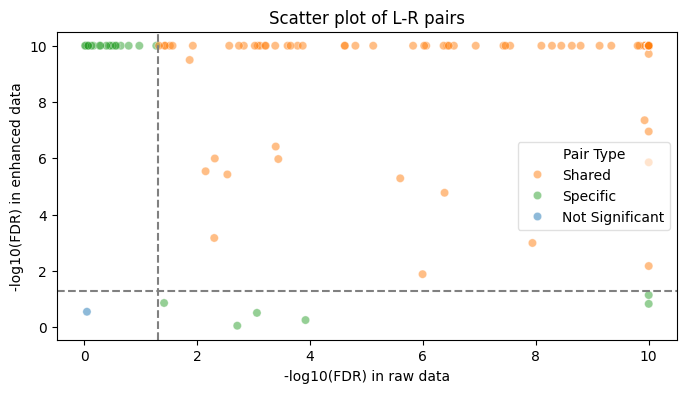

In [ ]:
plt.figure(figsize=(8, 4))

from matplotlib import colormaps as cm

c_list = cm.get_cmap('tab10').colors

sns.scatterplot(data=results, x='logFDR_raw', y='logFDR_enhanced', hue='pair_type', 
                palette={'Shared': c_list[1], 'Specific': c_list[2], 'Not Significant': c_list[0]}, alpha=0.5, legend=False)
plt.legend(title='Pair Type', loc='center left', bbox_to_anchor=(1, 0.5))

plt.axhline(y=-np.log10(0.05), linestyle='--', color='grey')
plt.axvline(x=-np.log10(0.05), linestyle='--', color='grey')
plt.title("Scatter plot of L-R pairs")
plt.xlabel("-log10(FDR) in raw data")
plt.ylabel("-log10(FDR) in enhanced data")
## set legend to outside the plot
plt.legend(title='Pair Type', loc='best', framealpha=0.6)
# plt.legend(title='Pair Type', loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('./figs/Nanostring/LR_pair_visualization.png', dpi=500)
plt.show()

In [40]:
import pandas as pd

df = pd.read_csv('figs/Nanostring/25-3-17/LR_pair_FDR.csv')
df.head()

,LR_pair,p_value,p_value_enhanced,FDR_raw,FDR_enhanced,logFDR_raw,logFDR_enhanced,Shared,Specific,Not Significant,pair_type,specific_enhanced
0,ADM2_RAMP1,4.539310e-180,0.000000e+00,9.556442e-180,0.000000e+00,10.000000,10.0,True,False,False,Shared,False
1,ANGPT1_ITGA5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,10.000000,10.0,True,False,False,Shared,False
2,ANGPT1_TEK,5.220943e-01,1.642648e-97,5.332027e-01,1.886295e-97,0.273108,10.0,False,True,False,Specific,True
3,ANGPT1_TIE1,2.302613e-30,0.000000e+00,3.131032e-30,0.000000e+00,10.000000,10.0,True,False,False,Shared,False
4,ANGPT2_TEK,4.105715e-37,1.349414e-156,5.745607e-37,1.623355e-156,10.000000,10.0,True,False,False,Shared,False


In [41]:
import numpy as np
thred = -np.log10(0.05)
conditions = [
    (df['logFDR_raw'] <= thred) & (df['logFDR_enhanced'] <= thred),  # 左下
    (df['logFDR_raw'] <= thred) & (df['logFDR_enhanced'] > thred),   # 左上
    (df['logFDR_raw'] > thred) & (df['logFDR_enhanced'] <= thred),   # 右下
    (df['logFDR_raw'] > thred) & (df['logFDR_enhanced'] > thred)     # 右上
]
choices = ['bottom-left', 'top-left', 'bottom-right', 'top-right']
df['region'] = np.select(conditions, choices, default='unknown')

# 统计各区域数量
counts = df['region'].value_counts()
print(counts)

region
top-right       452
top-left         21
bottom-right      6
bottom-left       1
Name: count, dtype: int64
